# Baseline simulation
This is a Jupyter notebook execution of the default performance test simulation.

In [5]:
from COVID19.model import Model, Parameters
import COVID19.simulation as simulation

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

In [6]:
sim   = simulation.Simulation(env = model, end_time = 200 )
sim.steps( 200 )

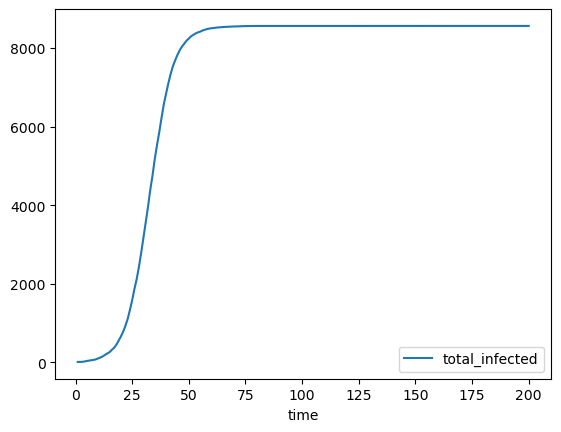

In [7]:
import pandas as pd
timeseries = pd.DataFrame( sim.results )
timeseries.plot( x = "time", y = "total_infected" )

## Extract network settings
We want to see how the probability of a person in each network becoming infected changes over time. Let us calculate the mean and variance for this probability for each network over the number of days in the simulation.

By default the model calculates the infectiousness hazard rate (the probability you will be infected by this interaction with this ill individual) from the network's combined transmission multiplier multiplied by the infector's infectiousness multiplier multipled by the strains infectiousness multiplied by the infectiousness for this strain on this day of infectiousness (i.e. the specific part of the infectiousness curve at this point in time). This is the interaction hazard value. See ../src/disease.c:111 transmit_virus_by_type() for details.

The strain infectious curve is a gamma_rate_curve distribution. See ../src/strain.c:42 initialise_infectious_curves(). This is static for a given day of being infectious as it's the same throughout the simulation for this strain.

The network transmission multiplier comes from a parameter for the simulation and is static throughout the simulation by the type of network. In the baseline parameters, for example, it is X for a household network, Y for a random network, and Z for a work network. See baseline_parameters.csv relative_transmission_household, relative_transmission_occupation, and relative_transmission_random parameters

The initial individual hazard probability is taken from the exponential distribution and is static for each individual throughout the whole simulation. This is divided by the adjusted susceptibility for that person's age group when setting up the simulation.

If the individual's static hazard value is less than this network interactions hazard value, then the individual is deemed to now be infected. See the new_infection() call in ../src/disease.c:174 transmit_virus_by_type() function.

All interactions throughout all networks of the same type thus have a static infectiousness multiplier which is only changed by the infectiousness of an individual in that network based on the number of days that individual has been infectious. Removing this from consideration, our network transmission multiplier values should be:-

Network | Mean Infectiousness | Variance of infectiousness
---|---|---
Work | 1 | 0
Home | 2 | 0
Random | 1 | 0

Let us try to calculate this from the model itself... (we'll calculate it over time even though we know its static so the code remains the same for future changes).


### Calculate mean and variance of infectiousness of all interactions across all networks of the same type
We expect to see the above table reproduced.
There will be no change to the number of infected.

WORK:     Count of networks:  200 , Mean:  1.0 , Variance:  0.0
HOME:     Count of networks:  200 , Mean:  2.0 , Variance:  0.0
RANDOM:   Count of networks:  1000 , Mean:  1.0 , Variance:  0.0


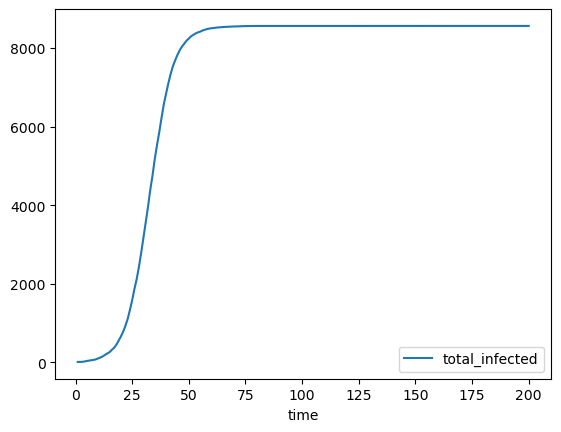

In [58]:
import numpy as np

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

valuesWork = []
valuesHome = []
valuesRandom = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesRandom.append(network.transmission_multiplier_combined())
        else:
            valuesWork.append(network.transmission_multiplier_combined())
                    
    
    # Run sim
    sim.steps(1)
    
timeseriesBaseline = pd.DataFrame( sim.results )
timeseriesBaseline.plot( x = "time", y = "total_infected" )

# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")

countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now change the multiplier to be completely random every simulation step from a uniform distribution
We expect to see a uniform distribution, and thus a mean of 0.5 and a standard deviation of 0.08333.
The overall number of infected may well change, as now the overall probability distribution across all interactions will be different from the three network types' fixed values.

WORK:     Count of networks:  200 , Mean:  0.4670654797879979 , Variance:  0.08666346621319185
HOME:     Count of networks:  200 , Mean:  0.9334115518361795 , Variance:  0.36479424722923404
RANDOM:   Count of networks:  1000 , Mean:  0.5128187930587447 , Variance:  0.08143961960387043


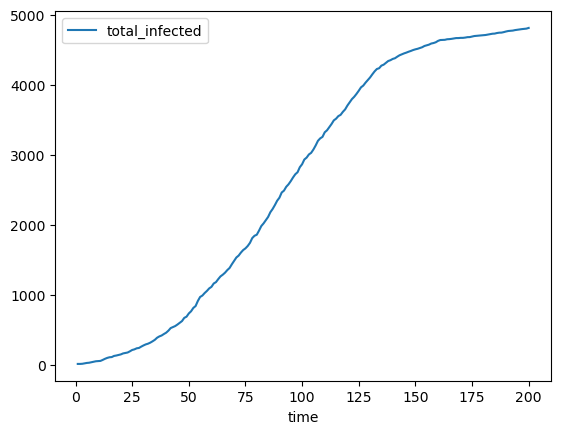

In [61]:
import numpy as np

from scipy.stats import uniform 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        randomValue = uniform.rvs(0.0,1.0)
        
        network.set_network_transmission_multiplier(randomValue)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesRandom.append(network.transmission_multiplier_combined())
        else:
            valuesWork.append(network.transmission_multiplier_combined())
                    
    
    # Run sim
    sim.steps(1)
    
timeseriesUniform = pd.DataFrame( sim.results )
timeseriesUniform.plot( x = "time", y = "total_infected" )

# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now do the same but from a Gamma distribution and random every simulation step
We expect to see the same mean and variance at a population level with the gamma distribution with Scale 1.

We expect to see more infections earlier on due to the skewness of the CDF of the gamma distribution when compared to a uniform distribution.

WORK:     Count of networks:  200 , Mean:  1.0062272028398 , Variance:  0.7444164534303309
HOME:     Count of networks:  200 , Mean:  2.130062214345671 , Variance:  4.1560291158448175
RANDOM:   Count of networks:  1000 , Mean:  1.0321213689108846 , Variance:  1.1409060617016464


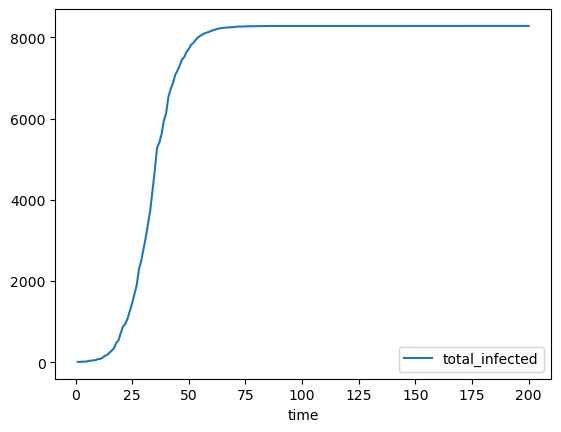

In [69]:
import numpy as np

from scipy.stats import gamma 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(0,underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        randomValue = gamma.rvs(1,scale=1)
        
        network.set_network_transmission_multiplier(randomValue)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesRandom.append(network.transmission_multiplier_combined())
        else:
            valuesWork.append(network.transmission_multiplier_combined())
                    
    
    # Run sim
    sim.steps(1)
    
timeseriesGamma = pd.DataFrame( sim.results )
timeseriesGamma.plot( x = "time", y = "total_infected" )

# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now create multiple network instances of the same type and see if it produces the same results
We want to move to a model where an individuals workplace is modelled exactly. This means we need multiple home and work networks simulated with different transmission probabilities rather than a single work instance with the same one and just a proportion of mixing happening within the network.
Let us modify the model to have 200 work places and 4000 homes but keep the 5 random networks. Let us use the same fixed probabilities as the original baseline parameters.
We should see the same infection curve as the baseline model with the same means and zero variance.

### Now reintroduce the Gamma distribution
We now modify the networks so they use the gamma distribution (shape=1), with a transmission probability fixed for each network instance (not network type as in the baseline) at the start of the simulation.
Again we expect to see the same infection curve but with variance matching our previous gamma model.

### Now change the random value to be a weighting from a given mean in the parameter file
We now modify the simulation so the randomness of infection probability lies between being fixed per network type and random for every interaction for every network instance. 
We will use the simulation parameter network transmissability number and treat it as the mean for the chosen distribution, then use the distribution per network instance at the start of the simulation to generate a per network transmissibility number. I.e. it is weighted.
We expect the mean to be the same as the original parameter, but the variance to be the same as the previous gamma set at start simulation.

## Summary
Below are the above simulations shown on the same chart

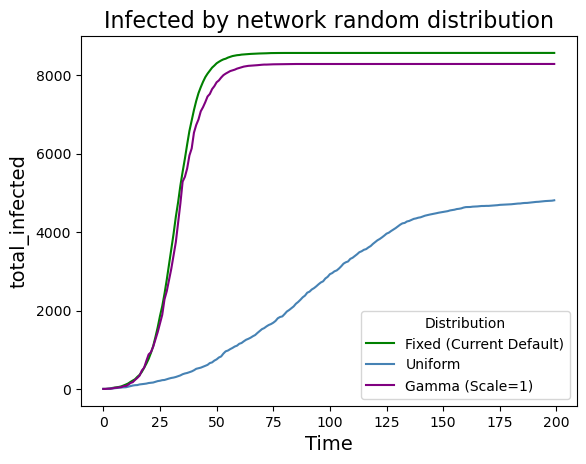

In [84]:
import matplotlib.pyplot as plt

plt.plot(timeseriesBaseline["total_infected"], label='Fixed (Current Default)', color='green')
plt.plot(timeseriesUniform["total_infected"], label='Uniform', color='steelblue')
plt.plot(timeseriesGamma["total_infected"], label='Gamma (Scale=1)', color='purple')

#add legend
plt.legend(title='Distribution')

#add axes labels and a title
plt.ylabel('total_infected', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Infected by network random distribution', fontsize=16)

plt.show()

## Next Steps
Next I shall add a parameter for each network called distribution with the following options:-
- Fixed (as the original baseline)
- Uniform per network simulation step
- Uniform per network simulation
- Gamma per network simulation step (shape=1)
- Gamma per network simulation (shape=1)
- Weighted Gamma per network simulation step (shape=1)
- Weighted Gamma per network simulation (shape=1)

This will allow us to reproduce the above simulations via a simple parameters file rather than in Jupyter notebook. This will require modification to the OpenABM-Covid19 C code base.